In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

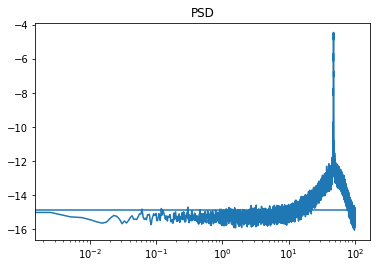

In [7]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [8]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

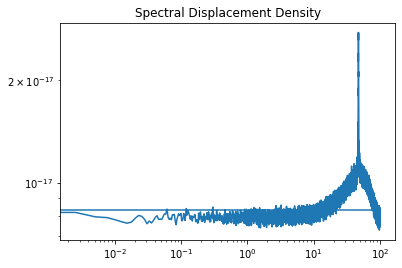

In [9]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [10]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [11]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

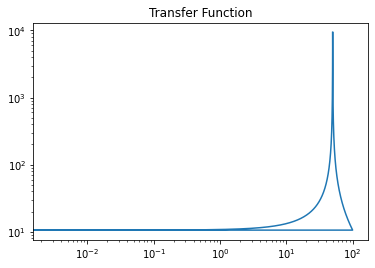

In [12]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

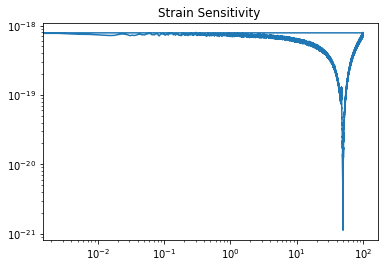

In [13]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

Text(0.5, 1.0, 'Transient Strain Sensitivity ')

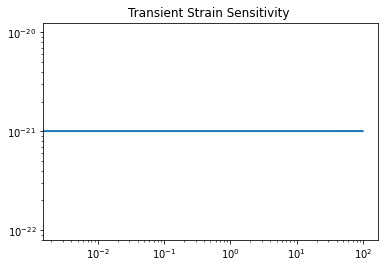

In [14]:
#DIFFERENCE ALGORITHM TESTING 

#create flat version of strain sensitivity to simulate simple broadband transient 
#print(np.min(h_1))
h_sim= [1e-21 for i in range(int(len(data1)/256))]

plt.plot(f_1+abs(np.min(f_1)), h_sim)
plt.xscale('log')
plt.yscale('log')
plt.title('Transient Strain Sensitivity ')

Text(0.5, 1.0, 'Sim Spectral Displacement Density')

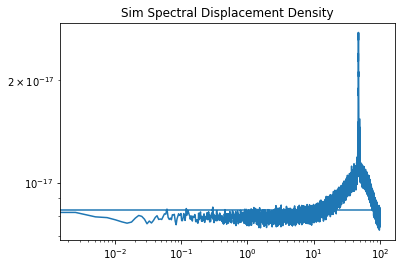

In [15]:
#multiply artificial h by H to get resulting square root of 
#spectral displacement density to add to data

sqrtSu_trans = [a*abs(b) for a,b in zip(h_sim, H_1)]

#plt.plot(f_1+abs(np.min(f_1)), sqrtSu_trans)
#plt.xscale('log')
#plt.yscale('log')
#plt.title('Transient Sim Spectral Displacement Density')

#add this to calibrated data (Su_1 from PSD of original data)

Su_sim = [a + b**2 for a,b in zip(Su1, sqrtSu_trans)]

plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su_sim))
plt.xscale('log')
plt.yscale('log')
plt.title('Sim Spectral Displacement Density')

[ 9.33306801e-18-7.94634181e-36j  1.14260205e-35-5.35685603e-36j
  8.04124359e-19-2.42083190e-20j -6.51251055e-36+7.49959451e-37j
  1.72124899e-19-4.90330774e-20j  4.51914697e-35-1.45727696e-34j
  1.47695386e-19-7.28233705e-20j  1.01976194e-35-1.50086307e-35j
  1.31290879e-19-8.92999911e-20j  9.50058693e-36+1.36549976e-35j]
78124


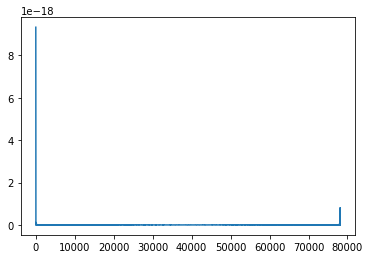

In [17]:
#Now need to get time series back from this PSD
Amp_sim = np.sqrt(Su_sim *2)
data_sim = np.fft.ifft(Amp_sim)

print(data_sim[:10])
print(len(data_sim))
plt.plot(abs(data_sim))

#issue here - sampling, phase consideration, not inverse of welch 

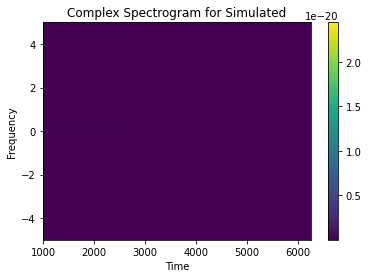

In [18]:
#PUT BACK INTO DIFFERENCING
#complex spectrogram
f, t, Sxx = signal.spectrogram(data_sim-np.mean(data_sim), 10, nperseg=20000, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx), axes=0), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram for Simulated')
plt.show()